In [1]:
import pandas as pd

# Load the dataset
file_path = "hp31_hr.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Convert the time column to datetime format and remove timezone information
df['time'] = pd.to_datetime(df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Sort the dataframe by time in increasing order
df_sorted = df.sort_values(by='time')

# Display the first few rows of the sorted dataframe
print(df_sorted.head())

                  time data_type  value
0  2024-10-24 00:00:00        hr     55
1  2024-10-24 00:01:00        hr     56
2  2024-10-24 00:02:00        hr     57
3  2024-10-24 00:03:00        hr     57
4  2024-10-24 00:04:00        hr     59


In [2]:
import pandas as pd

# Load the steps dataset
file_path_steps = "hp31_steps.csv"  # Replace with your actual file path
df_steps = pd.read_csv(file_path_steps)

# Convert the time column to datetime format and remove timezone information
df_steps['time'] = pd.to_datetime(df_steps['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Sort the dataframe by time in increasing order
df_steps_sorted = df_steps.sort_values(by='time')

# Display the first few rows of the sorted dataframe
print(df_steps_sorted.head())

                  time data_type  value
0  2024-10-24 01:08:00     steps     12
1  2024-10-24 01:33:00     steps      4
2  2024-10-24 02:51:00     steps      4
3  2024-10-24 02:53:00     steps      7
4  2024-10-24 05:31:00     steps      4


In [3]:
# Load the blood pressure dataset
file_path_bp = "blood_pressure_readings_ID31_cleaned.csv"  # Replace with your actual file path
df_bp = pd.read_csv(file_path_bp)

# Select relevant columns
df_bp = df_bp[['datetime_local', 'systolic', 'diastolic']]

# Convert the datetime column to datetime format
df_bp['datetime_local'] = pd.to_datetime(df_bp['datetime_local'])

# Sort the dataframe by datetime in increasing order
df_bp_sorted = df_bp.sort_values(by='datetime_local')

# Add a binary classification column for BP spikes
df_bp_sorted['BP_spike'] = ((df_bp_sorted['systolic'] > 130) | (df_bp_sorted['diastolic'] > 80)).astype(int)

# Count the number of BP spikes and total records
total_records = len(df_bp_sorted)
bp_spike_count = df_bp_sorted['BP_spike'].sum()

# Print summary
print(f"Total records: {total_records}")
print(f"Number of BP spikes: {bp_spike_count}")

# Display the first few rows of the processed dataframe
print(df_bp_sorted.head())

Total records: 391
Number of BP spikes: 112
       datetime_local  systolic  diastolic  BP_spike
0 2024-10-23 10:25:54       131         91         1
1 2024-10-23 11:03:16       121         78         0
7 2024-10-23 12:02:00       127         81         1
6 2024-10-23 13:10:49       146         83         1
5 2024-10-23 14:09:21       126         74         0


In [5]:
# Load the stress data dataset
file_path_stress = "questionnaire_responses_ID31.csv"  # Replace with your actual file path
df_stress = pd.read_csv(file_path_stress)

# Select relevant columns
df_stress = df_stress[['local_created_at', 'stressLevel_value']]

# Convert the time column to datetime format
df_stress['local_created_at'] = pd.to_datetime(df_stress['local_created_at'])

# Sort the dataframe by time in increasing order
df_stress_sorted = df_stress.sort_values(by='local_created_at')

# Display the first few rows of the processed dataframe
print(df_stress_sorted.head())

     local_created_at  stressLevel_value
0 2024-10-23 10:34:00                  2
1 2024-10-23 11:06:00                  1
2 2024-10-23 12:03:00                  2
3 2024-10-23 13:11:00                  4
4 2024-10-23 14:09:00                  2


In [6]:
import pandas as pd
import numpy as np

# 📌 **Step 1: Load Datasets**
file_path_hr = "hp31_hr.csv"
file_path_steps = "hp31_steps.csv"
file_path_bp = "blood_pressure_readings_ID31_cleaned.csv"
file_path_stress = "questionnaire_responses_ID31.csv"

df_hr = pd.read_csv(file_path_hr)
df_steps = pd.read_csv(file_path_steps)
df_bp = pd.read_csv(file_path_bp)
df_stress = pd.read_csv(file_path_stress)

# 📌 **Step 2: Convert timestamps to uniform `datetime64[ns]`**
df_hr['time'] = pd.to_datetime(df_hr['time']).dt.tz_localize(None)
df_steps['time'] = pd.to_datetime(df_steps['time']).dt.tz_localize(None)
df_bp['datetime_local'] = pd.to_datetime(df_bp['datetime_local']).dt.tz_localize(None)
df_stress['local_created_at'] = pd.to_datetime(df_stress['local_created_at']).dt.tz_localize(None)

# 📌 **Step 3: Remove Data from `2024-10-23` for BP & Stress**
df_bp = df_bp[df_bp['datetime_local'].dt.date > pd.to_datetime("2024-10-18").date()]
df_stress = df_stress[df_stress['local_created_at'].dt.date > pd.to_datetime("2024-10-18").date()]

# 📌 **Step 4: Sort datasets by time**
df_hr_sorted = df_hr.sort_values(by='time')
df_steps_sorted = df_steps.sort_values(by='time')
df_bp_sorted = df_bp.sort_values(by='datetime_local')
df_stress_sorted = df_stress.sort_values(by='local_created_at')

# 📌 **Step 5: Add BP spike classification**
df_bp_sorted['BP_spike'] = ((df_bp_sorted['systolic'] > 130) | (df_bp_sorted['diastolic'] > 80)).astype(int)

# 📌 **Step 6: Merge HR & Steps Data Based on Nearest Timestamp**
df_biosignals = pd.merge_asof(df_hr_sorted, df_steps_sorted, on='time', direction='backward', suffixes=('_hr', '_steps'))

# 📌 **Step 7: Compute Rolling Window Statistics for HR & Steps**
df_biosignals.set_index('time', inplace=True)
time_windows = [5, 10, 30, 60]  # Define time windows (minutes)

for window in time_windows:
    window_str = f"{window}min"
    df_biosignals[f'hr_mean_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").mean()
    df_biosignals[f'hr_min_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").min()
    df_biosignals[f'hr_max_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").max()
    df_biosignals[f'hr_std_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").std()

    df_biosignals[f'steps_total_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").sum()
    df_biosignals[f'steps_mean_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").mean()
    df_biosignals[f'steps_min_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").min()
    df_biosignals[f'steps_max_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").max()
    df_biosignals[f'steps_std_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").std()
    df_biosignals[f'steps_diff_{window_str}'] = df_biosignals[f'steps_max_{window_str}'] - df_biosignals[f'steps_min_{window_str}']

# Reset index after rolling computation
df_biosignals.reset_index(inplace=True)

# 📌 **Step 8: Merge BP Data with HR & Steps Features**
df_merged = pd.merge_asof(df_bp_sorted, df_biosignals, left_on='datetime_local', right_on='time', direction='backward')

# 📌 **Step 9: Incorporate Stress Data (±15 minutes window)**
def extract_stress_features(bp_time, df_stress):
    start_time = bp_time - pd.Timedelta(minutes=15)
    end_time = bp_time + pd.Timedelta(minutes=15)
    stress_values = df_stress[(df_stress['local_created_at'] >= start_time) & (df_stress['local_created_at'] <= end_time)]['stressLevel_value']
    
    return pd.Series({
        'stress_mean': stress_values.mean(),
        'stress_min': stress_values.min(),
        'stress_max': stress_values.max(),
        'stress_std': stress_values.std()
    })

df_stress_features = df_bp_sorted['datetime_local'].apply(lambda x: extract_stress_features(x, df_stress_sorted))
df_merged = pd.concat([df_merged, df_stress_features], axis=1)

# 📌 **Step 10: Create Additional Engineered Features**
# ✅ Lagged Features
lag_features = ['stress_mean', 'BP_spike', 'hr_mean_5min', 'steps_total_10min']
for feature in lag_features:
    for lag in [1, 3, 5]:  
        df_merged[f'{feature}_lag_{lag}'] = df_merged[feature].shift(lag)

# ✅ Feature Interactions
df_merged['hr_steps_ratio'] = df_merged['hr_mean_5min'] / (df_merged['steps_total_10min'] + 1)
df_merged['stress_weighted_hr'] = df_merged['hr_mean_5min'] * df_merged['stress_mean']
df_merged['stress_steps_ratio'] = df_merged['stress_mean'] / (df_merged['steps_total_10min'] + 1)
df_merged['steps_hr_variability_ratio'] = df_merged['steps_std_10min'] / (df_merged['hr_std_10min'] + 1e-5)

# ✅ Rolling Aggregations
df_merged['hr_mean_rolling_3'] = df_merged['hr_mean_5min'].rolling(3).mean()
df_merged['steps_total_rolling_5'] = df_merged['steps_total_10min'].rolling(5).mean()
df_merged['hr_std_rolling_3'] = df_merged['hr_std_10min'].rolling(3).std()
df_merged['cumulative_stress_30min'] = df_merged['stress_mean'].rolling(3).sum()
df_merged['cumulative_steps_30min'] = df_merged['steps_total_10min'].rolling(3).sum()

# ✅ Contextual Features
df_merged['hour_of_day'] = df_merged['datetime_local'].dt.hour
df_merged['day_of_week'] = df_merged['datetime_local'].dt.dayofweek
df_merged['is_working_hours'] = df_merged['hour_of_day'].between(9, 17).astype(int)
df_merged['is_weekend'] = (df_merged['day_of_week'] >= 5).astype(int)

# ✅ Time Since Last BP Spike
df_merged['time_since_last_BP_spike'] = df_merged['datetime_local'].diff().dt.total_seconds() / 60
df_merged['time_since_last_BP_spike'] = df_merged['time_since_last_BP_spike'].ffill()

# 📌 **Step 11: Handle Missing Values**
df_merged.ffill(inplace=True)  
df_merged.bfill(inplace=True)  # Fixes rolling feature NaNs at the beginning

# 📌 **Step 12: Save Processed Dataset**
df_merged.to_csv("processed_bp_prediction_data.csv", index=False)
print("✅ Final dataset saved as 'processed_bp_prediction_data.csv'.")
print(df_merged.head())


✅ Final dataset saved as 'processed_bp_prediction_data.csv'.
     id  user_id     reading_id             datetime      datetime_local  \
0  3060       31  1729715154000  2024-10-23 20:25:54 2024-10-23 10:25:54   
1  3061       31  1729717396000  2024-10-23 21:03:16 2024-10-23 11:03:16   
2  3079       31  1729720920000  2024-10-23 22:02:00 2024-10-23 12:02:00   
3  3078       31  1729725049000  2024-10-23 23:10:49 2024-10-23 13:10:49   
4  3077       31  1729728561000  2024-10-24 00:09:21 2024-10-23 14:09:21   

   systolic  diastolic  pulse  device_type           created_at  ...  \
0       131         91     71  HeartGuide™  2024-10-23 20:33:25  ...   
1       121         78     67  HeartGuide™  2024-10-23 21:08:25  ...   
2       127         81     67  HeartGuide™  2024-10-24 07:08:24  ...   
3       146         83     75  HeartGuide™  2024-10-24 07:08:24  ...   
4       126         74     67  HeartGuide™  2024-10-24 07:08:24  ...   

   hr_mean_rolling_3 steps_total_rolling_5 hr_std

In [7]:
# Load dataset
df_read = pd.read_csv("processed_bp_prediction_data.csv")

# Print all column names
print("🔹 Available Features in CSV File:")
for col in df_read.columns:
    print(col)

🔹 Available Features in CSV File:
id
user_id
reading_id
datetime
datetime_local
systolic
diastolic
pulse
device_type
created_at
BP_spike
time
data_type_hr
value_hr
data_type_steps
value_steps
hr_mean_5min
hr_min_5min
hr_max_5min
hr_std_5min
steps_total_5min
steps_mean_5min
steps_min_5min
steps_max_5min
steps_std_5min
steps_diff_5min
hr_mean_10min
hr_min_10min
hr_max_10min
hr_std_10min
steps_total_10min
steps_mean_10min
steps_min_10min
steps_max_10min
steps_std_10min
steps_diff_10min
hr_mean_30min
hr_min_30min
hr_max_30min
hr_std_30min
steps_total_30min
steps_mean_30min
steps_min_30min
steps_max_30min
steps_std_30min
steps_diff_30min
hr_mean_60min
hr_min_60min
hr_max_60min
hr_std_60min
steps_total_60min
steps_mean_60min
steps_min_60min
steps_max_60min
steps_std_60min
steps_diff_60min
stress_mean
stress_min
stress_max
stress_std
stress_mean_lag_1
stress_mean_lag_3
stress_mean_lag_5
BP_spike_lag_1
BP_spike_lag_3
BP_spike_lag_5
hr_mean_5min_lag_1
hr_mean_5min_lag_3
hr_mean_5min_lag_5
steps

🔹 BP Spike Counts Before SMOTE:
   - Training Set: 71 spikes (26.49%)
   - Test Set: 41 spikes (33.33%)

🔹 BP Spike Counts After SMOTE:
   - SMOTE Training Set: 137 spikes (41.02%)
🔹 Class Weights Applied: {0: 0.8477157360406091, 1: 1.218978102189781}
Epoch 1/30
11/11 [==============================] - 7s 197ms/step - loss: 0.6783 - accuracy: 0.5539 - val_loss: 0.6952 - val_accuracy: 0.5366
Epoch 2/30
11/11 [==============================] - 1s 80ms/step - loss: 0.6299 - accuracy: 0.6407 - val_loss: 0.6872 - val_accuracy: 0.5691
Epoch 3/30
11/11 [==============================] - 1s 79ms/step - loss: 0.6043 - accuracy: 0.6916 - val_loss: 0.6602 - val_accuracy: 0.6260
Epoch 4/30
11/11 [==============================] - 1s 89ms/step - loss: 0.5914 - accuracy: 0.6976 - val_loss: 0.6913 - val_accuracy: 0.5447
Epoch 5/30
11/11 [==============================] - 1s 88ms/step - loss: 0.5801 - accuracy: 0.7066 - val_loss: 0.6528 - val_accuracy: 0.6341
Epoch 6/30
11/11 [========================

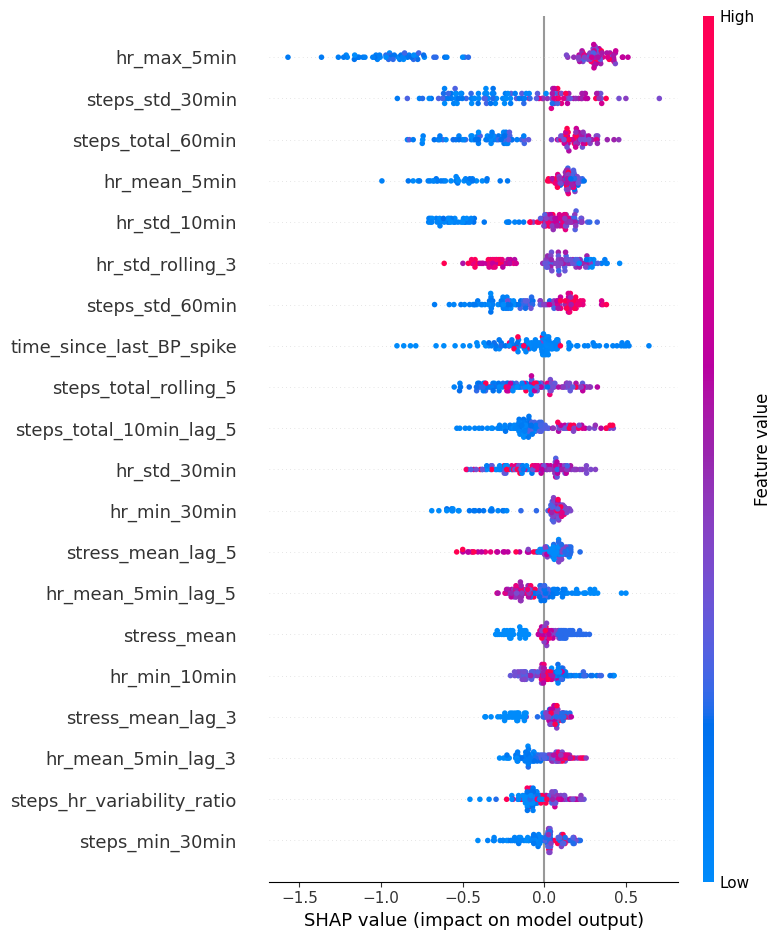


🔹 AUROC Score: 0.673
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.01 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.02 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.03 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.04 | Sensitivity: 1.00 | Specificity: 0.01
Threshold: 0.05 | Sensitivity: 1.00 | Specificity: 0.01
Threshold: 0.06 | Sensitivity: 1.00 | Specificity: 0.04
Threshold: 0.07 | Sensitivity: 1.00 | Specificity: 0.11
Threshold: 0.08 | Sensitivity: 0.98 | Specificity: 0.13
Threshold: 0.09 | Sensitivity: 0.93 | Specificity: 0.13
Threshold: 0.10 | Sensitivity: 0.93 | Specificity: 0.15
Threshold: 0.11 | Sensitivity: 0.90 | Specificity: 0.17
Threshold: 0.12 | Sensitivity: 0.90 | Specificity: 0.21
Threshold: 0.13 | Sensitivity: 0.90 | Specificity: 0.27
Threshold: 0.14 | Sensitivity: 0.90 | Specificity: 0.28
Threshold: 0.15 | Sensitivity: 0.90 | Specificity: 0.29
Threshold: 0.16 | Sensitivity: 0.90 | Specificity: 0.32
Threshold: 0.17 | Sensitiv

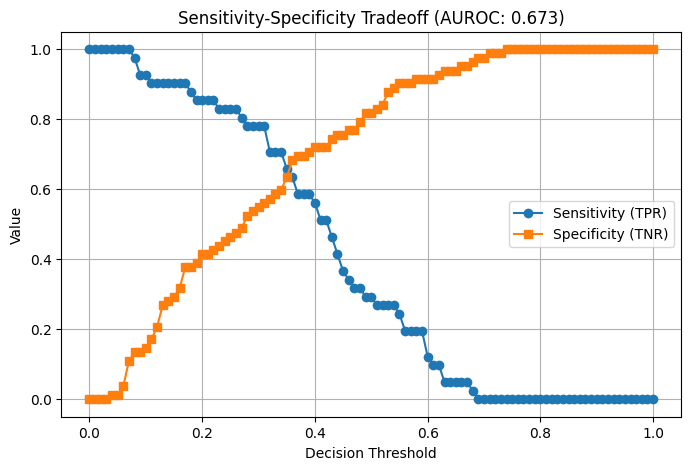

In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 📌 **Step 1: Load Processed Dataset**
df = pd.read_csv("processed_bp_prediction_data.csv")

# 📌 **Step 2: Define Features and Target**
features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

# Ensure numeric features
df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 📌 **Step 3: Split Data**
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)

train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# ✅ **Print BP Spike Counts**
print(f"🔹 BP Spike Counts Before SMOTE:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

# 📌 **Step 4: Handle Class Imbalance Using SMOTE**
smote = SMOTE(sampling_strategy=0.70, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ✅ **Print BP Spike Counts After SMOTE**
print(f"\n🔹 BP Spike Counts After SMOTE:")
print(f"   - SMOTE Training Set: {sum(y_train_smote)} spikes ({sum(y_train_smote)/len(y_train_smote)*100:.2f}%)")

# 📌 **Step 5: Compute Class Weights for LSTM**
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_smote), y=y_train_smote)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights Applied: {class_weight_dict}")

# 📌 **Step 6: Standardize Features**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# 📌 **Step 7: Train XGBoost Model**
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.05, random_state=42)
xgb_clf.fit(X_train_scaled, y_train_smote)

# 📌 **Step 8: Train LSTM Model**
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_smote, epochs=30, batch_size=32, validation_data=(X_test_lstm, y_test), class_weight=class_weight_dict)

# 📌 **Step 9: Model Predictions**
y_pred_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# 📌 **Step 10: SHAP Analysis**
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=features)

# 📌 **Step 11: Adjust Alpha & Beta for Model Fusion**
alpha = 0.30  # XGBoost weight
beta = 0.70   # LSTM weight

y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)

# 📌 **Step 12: Compute AUROC**
auroc_score = roc_auc_score(y_test, y_pred_final)
print(f"\n🔹 AUROC Score: {auroc_score:.3f}")

# 📌 **Step 13: Compute Sensitivity and Specificity for All Thresholds**
thresholds = np.arange(0, 1.01, 0.01)
sensitivity_list, specificity_list = [], []

for threshold in thresholds:
    y_pred_binary = (y_pred_final >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f}")

# 📌 **Step 14: Compute Final Sensitivity & Specificity at Optimal Threshold**
optimal_threshold = 0.5
y_pred_binary = (y_pred_final >= optimal_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
final_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
final_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n🔹 Final Sensitivity (Recall): {final_sensitivity:.3f}")
print(f"🔹 Final Specificity: {final_specificity:.3f}")

# 📌 **Step 15: Sensitivity-Specificity Plot**
plt.figure(figsize=(8, 5))
plt.plot(thresholds, sensitivity_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, specificity_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (AUROC: {auroc_score:.3f})")
plt.legend()
plt.grid()
plt.show()


Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.7154471278190613

Best val_accuracy So Far: 0.7235772609710693
Total elapsed time: 00h 09m 28s

4/4 [==============================] - 1s 56ms/step


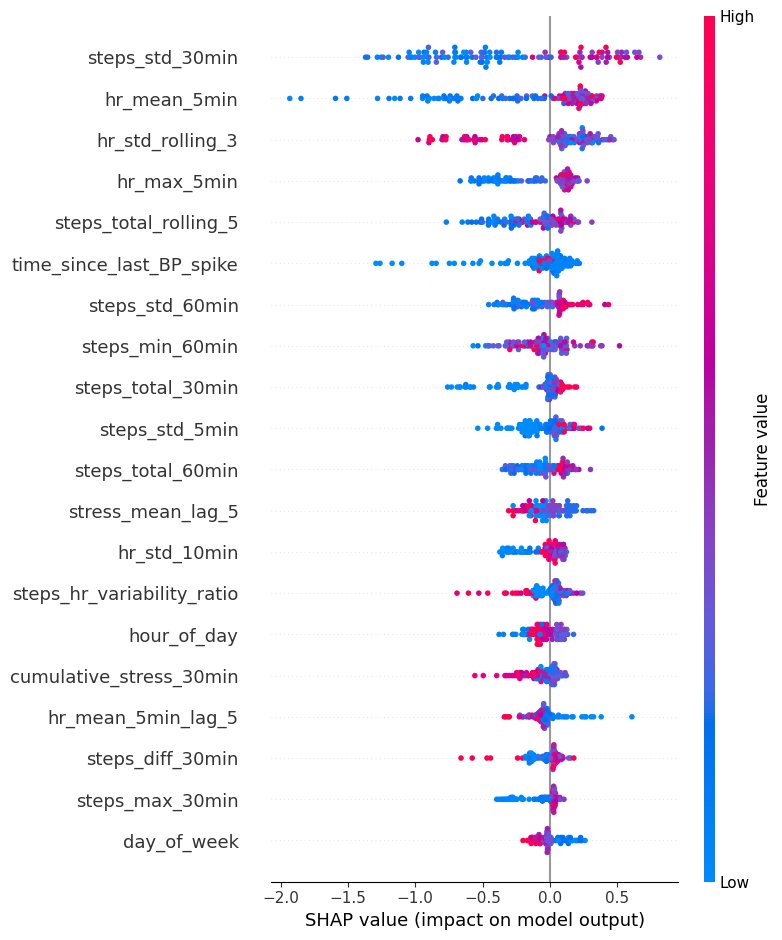


🔹 AUROC Score: 0.656
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.01 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.02 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.03 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.04 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.05 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.06 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.07 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.08 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.09 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.10 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.11 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.12 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.13 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.14 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.15 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.16 | Sensitivity: 1.00 | Specificity: 0.00
Threshold: 0.17 | Sensitiv

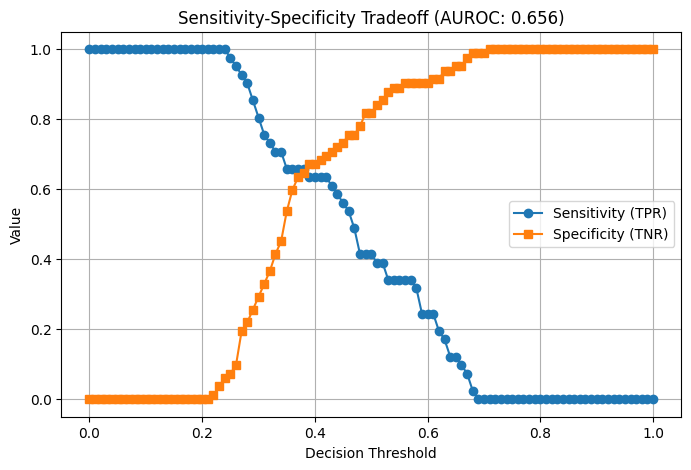

In [39]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN  # You can also try BorderlineSMOTE if desired
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt  # For hyperparameter tuning of the LSTM

# ============================
# Step 1: Load Processed Dataset
# ============================
df = pd.read_csv("processed_bp_prediction_data.csv")

# ============================
# Step 2: Define Features and Target
# ============================
features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

# Ensure numeric features
df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ============================
# Step 3: Split Data into Training and Test Sets
# ============================
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

# ============================
# Step 4: Handle Class Imbalance Using Alternative Resampling (ADASYN)
# ============================
adasyn = ADASYN(sampling_strategy=0.70, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print("\n🔹 BP Spike Counts After ADASYN Resampling:")
print(f"   - Resampled Training Set: {sum(y_train_resampled)} spikes ({sum(y_train_resampled)/len(y_train_resampled)*100:.2f}%)")

# ============================
# Step 5: Compute Class Weights for LSTM Training
# ============================
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train_resampled),
                                     y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights Applied: {class_weight_dict}")

# ============================
# Step 6: Standardize Features
# ============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# ============================
# Step 7: Hyperparameter Optimization for XGBoost with Cost-Sensitive Learning
# ============================
# Compute scale_pos_weight using the original (pre-resampled) training data
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 scale_pos_weight for XGBoost: {scale_pos_weight}")

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'scale_pos_weight': [scale_pos_weight]  # Incorporate cost sensitivity
}

xgb_clf = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_resampled)
print("🔹 Best parameters for XGBoost found: ", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

# ============================
# Step 8: Hyperparameter Optimization for LSTM Using Keras Tuner
# ============================
# Reshape data for LSTM input: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

def build_model(hp):
    model = Sequential()
    # Tune first LSTM layer units
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Tune second LSTM layer units
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2))
    model.add(Dense(1, activation='sigmoid'))
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction'
)

tuner.search(X_train_lstm, y_train_resampled,
             epochs=30,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]

# ============================
# Step 9: Model Predictions
# ============================
y_pred_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

# ============================
# Step 10: SHAP Analysis for XGBoost
# ============================
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=features)

# ============================
# Step 11: Adjust Alpha & Beta for Model Fusion
# ============================
alpha = 0.30  # Weight for XGBoost
beta = 0.70   # Weight for LSTM
y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)

# ============================
# Step 12: Compute AUROC
# ============================
auroc_score = roc_auc_score(y_test, y_pred_final)
print(f"\n🔹 AUROC Score: {auroc_score:.3f}")

# ============================
# Step 13: Compute Sensitivity and Specificity for All Thresholds
# ============================
thresholds = np.arange(0, 1.01, 0.01)
sensitivity_list, specificity_list = [], []

for threshold in thresholds:
    y_pred_binary = (y_pred_final >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f}")

# ============================
# Step 14: Compute Final Sensitivity & Specificity at Optimal Threshold
# ============================
optimal_threshold = 0.5
y_pred_binary = (y_pred_final >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
final_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
final_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"\n🔹 Final Sensitivity (Recall): {final_sensitivity:.3f}")
print(f"🔹 Final Specificity: {final_specificity:.3f}")

# ============================
# Step 15: Sensitivity-Specificity Plot
# ============================
plt.figure(figsize=(8, 5))
plt.plot(thresholds, sensitivity_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, specificity_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (AUROC: {auroc_score:.3f})")
plt.legend()
plt.grid()
plt.show()


## Changing the LSTM architecture to make it more effective and contributive on the final prediction

Trial 10 Complete [00h 01m 20s]
val_auc: 0.6195716857910156

Best val_auc So Far: 0.705532431602478
Total elapsed time: 00h 11m 50s
🔹 Best LSTM hyperparameters:
{'lstm_units': 192, 'dropout_rate': 0.2, 'lstm_units_2': 80, 'dense_units': 64, 'learning_rate': 0.001}
4/4 [==============================] - 2s 72ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.706
Alpha: 0.10, Beta: 0.90, AUROC: 0.709
Alpha: 0.20, Beta: 0.80, AUROC: 0.711
Alpha: 0.30, Beta: 0.70, AUROC: 0.706
Alpha: 0.40, Beta: 0.60, AUROC: 0.705
Alpha: 0.50, Beta: 0.50, AUROC: 0.698
Alpha: 0.60, Beta: 0.40, AUROC: 0.697
Alpha: 0.70, Beta: 0.30, AUROC: 0.696
Alpha: 0.80, Beta: 0.20, AUROC: 0.690
Alpha: 0.90, Beta: 0.10, AUROC: 0.686
Alpha: 1.00, Beta: 0.00, AUROC: 0.678

🔹 Best Ensemble Weights: Alpha = 0.20, Beta = 0.80, AUROC = 0.711
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshold: 0.01 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshold: 0

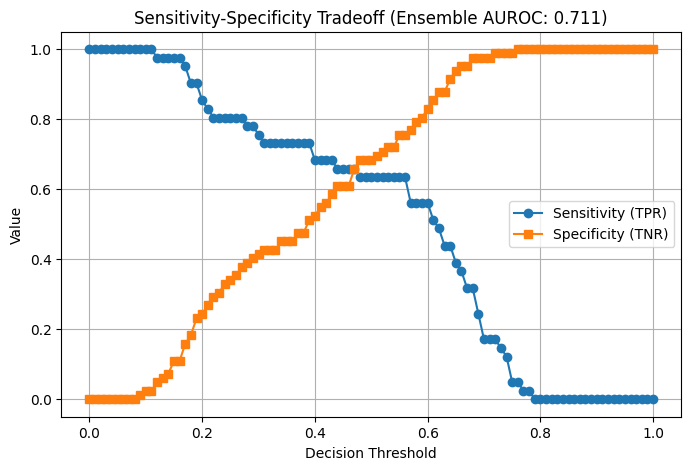

In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

# Ensure numeric features
df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ============================
# Split Data into Training and Test Sets
# ============================
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
# Build an imblearn pipeline with scaling, ADASYN, and XGBoost.
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),  # sampling_strategy will be tuned
    ('xgb', xgb.XGBClassifier(random_state=42))
])

# Compute scale_pos_weight using the original training distribution.
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

# Define grid of hyperparameters including ADASYN's sampling_strategy.
param_grid = {
    'adasyn__sampling_strategy': [0.60, 0.65, 0.70, 0.75],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

# Save the best pipeline (which includes the best ADASYN ratio and XGBoost parameters).
best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
# Scale data for LSTM training.
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

# Use the best ADASYN sampling strategy from grid search for LSTM training.
best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

# Reshape data for LSTM input: (samples, timesteps, features).
X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

# Compute class weights for LSTM training.
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

# Improved LSTM Model with Bidirectional LSTM and Additional Dense Layers
def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (unidirectional)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Additional Dense layer for further feature extraction
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# IMPORTANT: Specify the objective with direction for Keras Tuner.
# Adding overwrite=True to ignore previous checkpoints.
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=30,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
# Get XGBoost predictions using the best pipeline.
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]

# Get LSTM predictions.
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

# Grid search over ensemble weights (assuming α + β = 1).
alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()


## Only 1 custom attention mechanisms added.

Trial 10 Complete [00h 01m 31s]
val_auc: 0.7141582369804382

Best val_auc So Far: 0.7566924691200256
Total elapsed time: 00h 22m 20s
🔹 Best LSTM hyperparameters:
{'lstm_units': 128, 'dropout_rate': 0.2, 'lstm_units_2': 48, 'dense_units': 16, 'dense_reg': 0.0, 'learning_rate': 0.0005}
4/4 [==============================] - 2s 78ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.759
Alpha: 0.10, Beta: 0.90, AUROC: 0.763
Alpha: 0.20, Beta: 0.80, AUROC: 0.761
Alpha: 0.30, Beta: 0.70, AUROC: 0.762
Alpha: 0.40, Beta: 0.60, AUROC: 0.756
Alpha: 0.50, Beta: 0.50, AUROC: 0.747
Alpha: 0.60, Beta: 0.40, AUROC: 0.736
Alpha: 0.70, Beta: 0.30, AUROC: 0.723
Alpha: 0.80, Beta: 0.20, AUROC: 0.709
Alpha: 0.90, Beta: 0.10, AUROC: 0.698
Alpha: 1.00, Beta: 0.00, AUROC: 0.678

🔹 Best Ensemble Weights: Alpha = 0.10, Beta = 0.90, AUROC = 0.763
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshold: 0.01 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Inde

Threshold: 0.98 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 0.99 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 1.00 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00

🔹 Best Threshold in [0,1]: 0.64
🔹 Final Sensitivity (Recall): 0.780
🔹 Final Specificity: 0.707


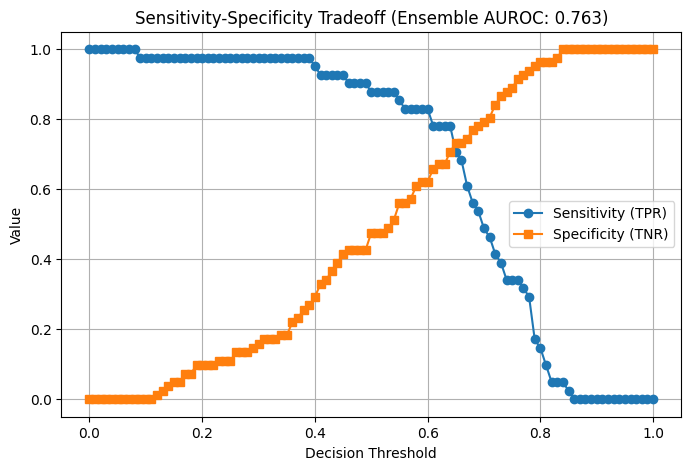

In [44]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# Custom Attention Layer
#############################################
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        # x: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = tf.keras.backend.softmax(e, axis=1)  # (batch_size, time_steps, 1)
        output = x * a  # (batch_size, time_steps, features)
        return tf.keras.backend.sum(output, axis=1)  # (batch_size, features)

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

# Ensure numeric features
df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ============================
# Split Data into Training and Test Sets
# ============================
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),  # tuning sampling_strategy
    ('xgb', xgb.XGBClassifier(random_state=42))
])

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

param_grid = {
    'adasyn__sampling_strategy': [0.60, 0.65, 0.70, 0.75],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

# Improved LSTM Model with Attention and Regularization Grid
def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM (return sequences)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), 
                            input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (return sequences for attention)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Attention layer to get context vector from LSTM outputs
    model.add(AttentionLayer())
    # Additional Dense layer with L2 regularization (grid search)
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_reg = hp.Choice('dense_reg', values=[0.0, 0.001, 0.01, 0.1])
    model.add(Dense(dense_units, activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.l2(dense_reg)))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# IMPORTANT: Overwrite previous tuner results to avoid checkpoint mismatches.
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

# Increase epochs to 50
tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=50,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()


In [ ]:
## Including 2 attention mechanisms into the grid search: Custom, Multihead

Trial 10 Complete [00h 02m 01s]
val_auc: 0.692444920539856

Best val_auc So Far: 0.758328378200531
Total elapsed time: 00h 24m 26s
🔹 Best LSTM hyperparameters:
{'lstm_units': 96, 'dropout_rate': 0.4, 'lstm_units_2': 48, 'attention_variant': 'multihead', 'dense_units': 48, 'dense_reg': 0.0, 'learning_rate': 0.001, 'num_heads': 1, 'key_dim': 48}
4/4 [==============================] - 2s 39ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.760
Alpha: 0.10, Beta: 0.90, AUROC: 0.759
Alpha: 0.20, Beta: 0.80, AUROC: 0.760
Alpha: 0.30, Beta: 0.70, AUROC: 0.761
Alpha: 0.40, Beta: 0.60, AUROC: 0.760
Alpha: 0.50, Beta: 0.50, AUROC: 0.757
Alpha: 0.60, Beta: 0.40, AUROC: 0.754
Alpha: 0.70, Beta: 0.30, AUROC: 0.745
Alpha: 0.80, Beta: 0.20, AUROC: 0.725
Alpha: 0.90, Beta: 0.10, AUROC: 0.700
Alpha: 1.00, Beta: 0.00, AUROC: 0.678

🔹 Best Ensemble Weights: Alpha = 0.30, Beta = 0.70, AUROC = 0.761
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshol

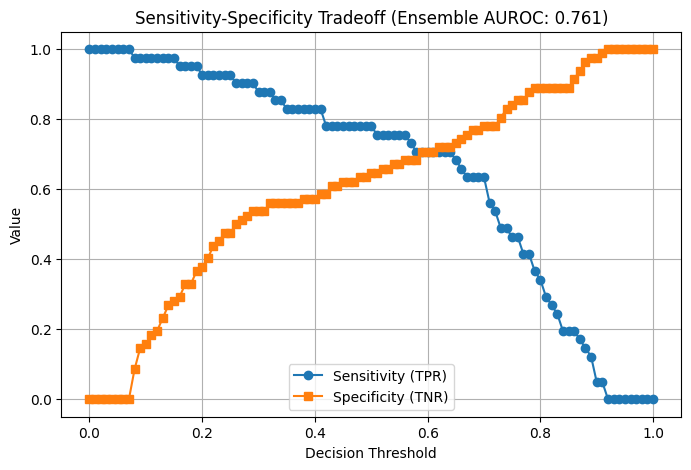

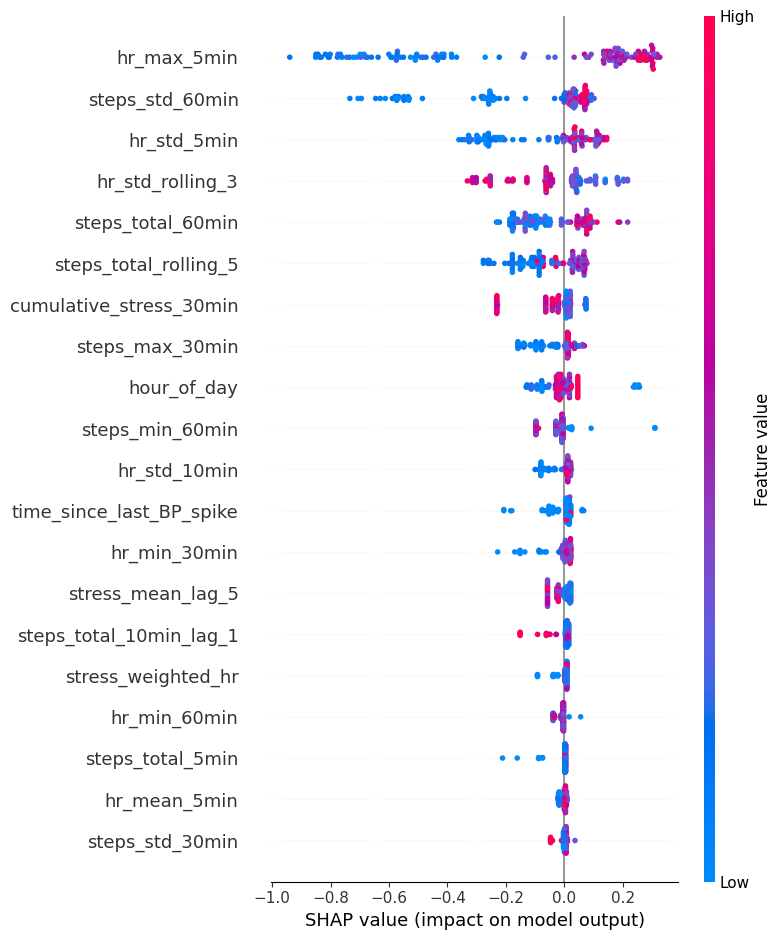

Total training time: 1541.39 seconds


In [46]:
import time
start_time = time.time()

import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# Custom Attention Layers
#############################################
# 1. Custom (simple) Attention Layer (as before)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        # x: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = tf.keras.backend.softmax(e, axis=1)  # (batch_size, time_steps, 1)
        output = x * a  # (batch_size, time_steps, features)
        return tf.keras.backend.sum(output, axis=1)  # (batch_size, features)

# 2. MultiHeadAttention Layer wrapped in a custom layer
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)

    def call(self, inputs):
        # Use inputs as query, key, and value.
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        # Global average pooling over the time dimension.
        return tf.reduce_mean(attn_output, axis=1)

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

# Ensure numeric features
df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ============================
# Split Data into Training and Test Sets
# ============================
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),  # tuning sampling_strategy
    ('xgb', xgb.XGBClassifier(random_state=42))
])

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

param_grid = {
    'adasyn__sampling_strategy': [0.60, 0.65, 0.70, 0.75],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

# Improved LSTM Model with Attention variants and Regularization
def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM (return sequences)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True),
                            input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (return sequences for attention)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Attention variant selection:
    att_variant = hp.Choice('attention_variant', ['custom', 'multihead'])
    if att_variant == 'custom':
        # Use custom attention layer.
        model.add(AttentionLayer())
    else:
        # Use the custom MultiHeadAttentionLayer instead of a Lambda.
        num_heads = hp.Int('num_heads', min_value=1, max_value=4, step=1)
        key_dim = hp.Int('key_dim', min_value=16, max_value=64, step=16)
        model.add(MultiHeadAttentionLayer(num_heads=num_heads, key_dim=key_dim))
    
    # Additional Dense layer with L2 regularization
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_reg = hp.Choice('dense_reg', values=[0.0, 0.001, 0.01, 0.1])
    model.add(Dense(dense_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(dense_reg)))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# IMPORTANT: Overwrite previous tuner results.
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

# Increase epochs to 50
tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=50,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()

#############################################
# 7. SHAP Analysis for XGBoost Model
#############################################
scaler_xgb = best_xgb_pipeline.named_steps['scaler']
xgb_model = best_xgb_pipeline.named_steps['xgb']
X_test_scaled_for_shap = scaler_xgb.transform(X_test)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled_for_shap)
shap.summary_plot(shap_values, X_test, feature_names=features)

#############################################
# 8. Print Total Training Time
#############################################
end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))


## Including 3 attention mechanisms into the grid search: Custom, multihead, self attention

Trial 10 Complete [00h 02m 24s]
val_auc: 0.6876859068870544

Best val_auc So Far: 0.7544616460800171
Total elapsed time: 00h 26m 22s
🔹 Best LSTM hyperparameters:
{'lstm_units': 224, 'dropout_rate': 0.2, 'lstm_units_2': 64, 'attention_variant': 'custom', 'dense_units': 16, 'dense_reg': 0.01, 'learning_rate': 0.0005}
4/4 [==============================] - 4s 136ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.753
Alpha: 0.10, Beta: 0.90, AUROC: 0.762
Alpha: 0.20, Beta: 0.80, AUROC: 0.762
Alpha: 0.30, Beta: 0.70, AUROC: 0.761
Alpha: 0.40, Beta: 0.60, AUROC: 0.753
Alpha: 0.50, Beta: 0.50, AUROC: 0.748
Alpha: 0.60, Beta: 0.40, AUROC: 0.738
Alpha: 0.70, Beta: 0.30, AUROC: 0.723
Alpha: 0.80, Beta: 0.20, AUROC: 0.710
Alpha: 0.90, Beta: 0.10, AUROC: 0.697
Alpha: 1.00, Beta: 0.00, AUROC: 0.678

🔹 Best Ensemble Weights: Alpha = 0.10, Beta = 0.90, AUROC = 0.762
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshold: 0.01 | Sensitivity: 1.00 

Threshold: 0.96 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 0.97 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 0.98 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 0.99 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 1.00 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00

🔹 Best Threshold in [0,1]: 0.62
🔹 Final Sensitivity (Recall): 0.902
🔹 Final Specificity: 0.500


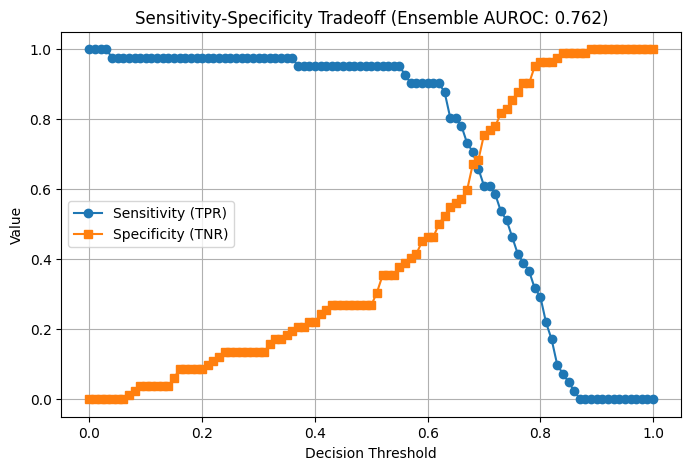

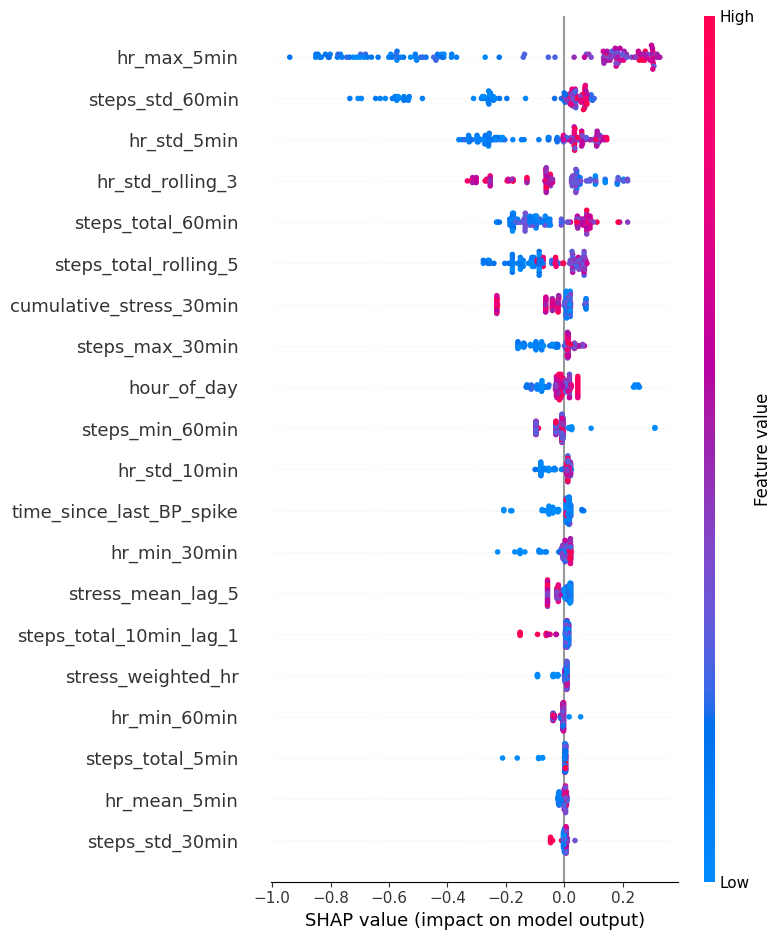

Total training time: 1657.68 seconds


In [47]:
import time
start_time = time.time()

import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# Custom Attention Layers
#############################################
# 1. Custom (simple) Attention Layer (as before)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        # x: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = tf.keras.backend.softmax(e, axis=1)  # (batch_size, time_steps, 1)
        output = x * a  # (batch_size, time_steps, features)
        return tf.keras.backend.sum(output, axis=1)  # (batch_size, features)

# 2. MultiHeadAttention Layer wrapped in a custom layer
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)
    def call(self, inputs):
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        return tf.reduce_mean(attn_output, axis=1)

# 3. Self-Attention Layer using tf.keras.layers.Attention
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)
        self.att = tf.keras.layers.Attention()
    def call(self, x):
        att_out = self.att([x, x])
        return tf.reduce_mean(att_out, axis=1)

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

param_grid = {
    'adasyn__sampling_strategy': [0.60, 0.65, 0.70, 0.75],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM (return sequences)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True),
                            input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (return sequences for attention)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Attention variant selection: choose among 'custom', 'multihead', and 'selfattention'
    att_variant = hp.Choice('attention_variant', ['custom', 'multihead', 'selfattention'])
    if att_variant == 'custom':
        model.add(AttentionLayer())
    elif att_variant == 'multihead':
        num_heads = hp.Int('num_heads', min_value=1, max_value=4, step=1)
        key_dim = hp.Int('key_dim', min_value=16, max_value=64, step=16)
        model.add(MultiHeadAttentionLayer(num_heads=num_heads, key_dim=key_dim))
    else:  # 'selfattention'
        model.add(SelfAttentionLayer())
    
    # Additional Dense layer with L2 regularization
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_reg = hp.Choice('dense_reg', values=[0.0, 0.001, 0.01, 0.1])
    model.add(Dense(dense_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(dense_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

# Increase epochs to 50
tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=50,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()

#############################################
# 7. SHAP Analysis for XGBoost Model
#############################################
scaler_xgb = best_xgb_pipeline.named_steps['scaler']
xgb_model = best_xgb_pipeline.named_steps['xgb']
X_test_scaled_for_shap = scaler_xgb.transform(X_test)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled_for_shap)
shap.summary_plot(shap_values, X_test, feature_names=features)

#############################################
# 8. Print Total Training Time
#############################################
end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))


## Including 4 attection based mechanisms into the grid search: Custom, multihead, self attention, transformer block

Trial 10 Complete [00h 02m 38s]
val_auc: 0.7297738790512085

Best val_auc So Far: 0.7376561760902405
Total elapsed time: 00h 29m 20s
🔹 Best LSTM hyperparameters:
{'lstm_units': 192, 'dropout_rate': 0.2, 'lstm_units_2': 32, 'attention_variant': 'selfattention', 'dense_units': 16, 'dense_reg': 0.0, 'learning_rate': 0.0005}
4/4 [==============================] - 2s 86ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.738
Alpha: 0.10, Beta: 0.90, AUROC: 0.736
Alpha: 0.20, Beta: 0.80, AUROC: 0.736
Alpha: 0.30, Beta: 0.70, AUROC: 0.735
Alpha: 0.40, Beta: 0.60, AUROC: 0.731
Alpha: 0.50, Beta: 0.50, AUROC: 0.724
Alpha: 0.60, Beta: 0.40, AUROC: 0.720
Alpha: 0.70, Beta: 0.30, AUROC: 0.710
Alpha: 0.80, Beta: 0.20, AUROC: 0.700
Alpha: 0.90, Beta: 0.10, AUROC: 0.688
Alpha: 1.00, Beta: 0.00, AUROC: 0.678

🔹 Best Ensemble Weights: Alpha = 0.00, Beta = 1.00, AUROC = 0.738
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
Threshold: 0.01 | Sensitivity: 

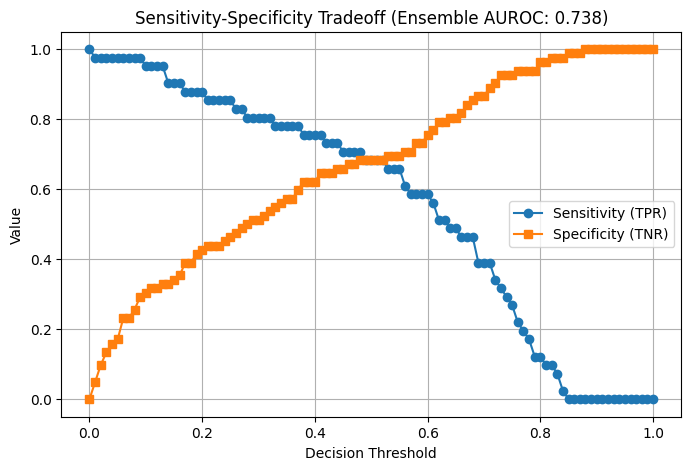

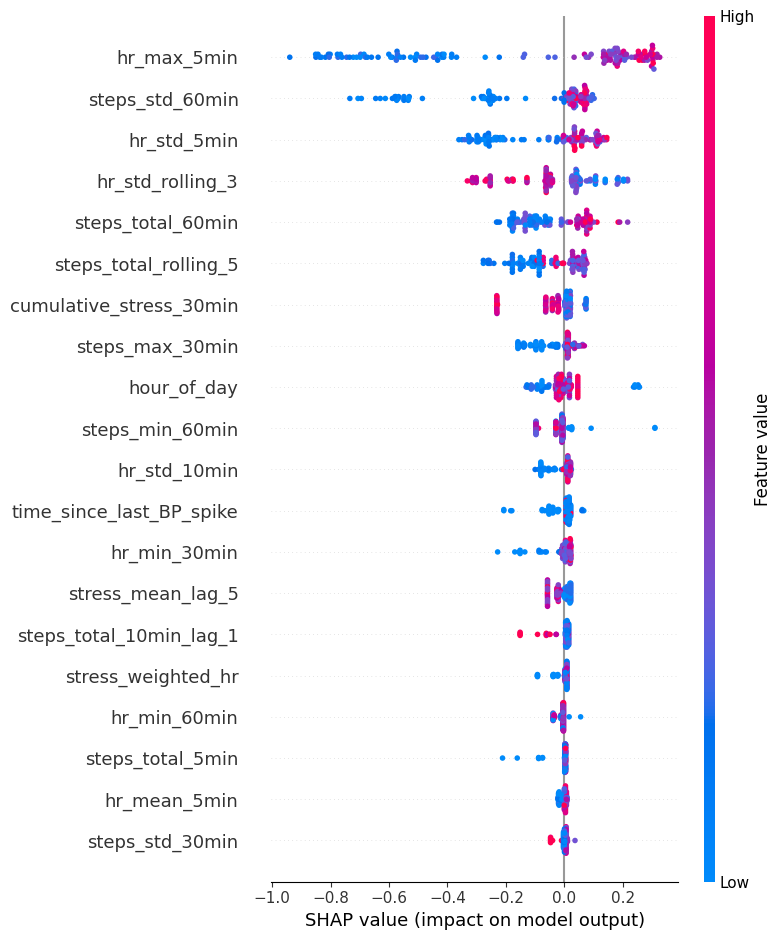

Total training time: 1839.67 seconds


In [49]:
import time
start_time = time.time()

import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# Custom Attention Layers
#############################################
# 1. Custom (simple) Attention Layer (as before)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# 2. MultiHeadAttention Layer wrapped in a custom layer
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)
    def call(self, inputs):
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        return tf.reduce_mean(attn_output, axis=1)

# 3. Self-Attention Layer using tf.keras.layers.Attention
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)
        self.att = tf.keras.layers.Attention()
    def call(self, x):
        att_out = self.att([x, x])
        return tf.reduce_mean(att_out, axis=1)

# 4. Transformer Block as a custom layer with corrected dimensions
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.ff_dim = ff_dim
        self.rate = rate
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def build(self, input_shape):
        # Set embed_dim equal to the last dimension of the input
        self.embed_dim = input_shape[-1]
        self.ffn = Sequential([
            Dense(self.ff_dim, activation='relu'),
            Dense(self.embed_dim)
        ])
        super(TransformerBlock, self).build(input_shape)
    def call(self, inputs, training=False):
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max', 'stress_std',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=20)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

param_grid = {
    'adasyn__sampling_strategy': [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM (return sequences)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True),
                            input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (return sequences for attention)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Attention variant selection: choose among 'custom', 'multihead', 'selfattention', 'transformer'
    att_variant = hp.Choice('attention_variant', ['custom', 'multihead', 'selfattention', 'transformer'])
    if att_variant == 'custom':
        model.add(AttentionLayer())
    elif att_variant == 'multihead':
        num_heads = hp.Int('num_heads', min_value=1, max_value=4, step=1)
        key_dim = hp.Int('key_dim', min_value=16, max_value=64, step=16)
        model.add(MultiHeadAttentionLayer(num_heads=num_heads, key_dim=key_dim))
    elif att_variant == 'selfattention':
        model.add(SelfAttentionLayer())
    else:  # transformer variant
        trans_num_heads = hp.Int('trans_num_heads', min_value=1, max_value=4, step=1)
        trans_key_dim = hp.Int('trans_key_dim', min_value=16, max_value=64, step=16)
        ff_dim = hp.Int('ff_dim', min_value=32, max_value=128, step=32)
        transformer_block = TransformerBlock(num_heads=trans_num_heads, key_dim=trans_key_dim, ff_dim=ff_dim, rate=dropout_rate)
        model.add(transformer_block)
        model.add(GlobalAveragePooling1D())
    
    # Additional Dense layer with L2 regularization
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_reg = hp.Choice('dense_reg', values=[0.0, 0.001, 0.01, 0.1])
    model.add(Dense(dense_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(dense_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=20,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=50,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()

#############################################
# 7. SHAP Analysis for XGBoost Model
#############################################
scaler_xgb = best_xgb_pipeline.named_steps['scaler']
xgb_model = best_xgb_pipeline.named_steps['xgb']
X_test_scaled_for_shap = scaler_xgb.transform(X_test)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled_for_shap)
shap.summary_plot(shap_values, X_test, feature_names=features)

#############################################
# 8. Print Total Training Time
#############################################
end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))


In [50]:
print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes out of {len(y_train)} samples ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes out of {len(y_test)} samples ({sum(y_test)/len(y_test)*100:.2f}%)")

🔹 BP Spike Counts Before Resampling:
   - Training Set: 71 spikes out of 268 samples (26.49%)
   - Test Set: 41 spikes out of 123 samples (33.33%)
